# Digital Image Processing<br> Problem 9<br> Felix Neutatz

##Image segmentation

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import partial
from random import randint

In [4]:
def plotGreyImage(imageToPlot, title):
    plt.imshow(imageToPlot, cmap='gray') #Greys_r
    plt.title(title)
    plt.axis('off')
    plt.show()

### (a). Develop a program to implement the Roberts, Prewitt,Sobel, the Marr-Hildreth and the Canny edge detectors.

In [10]:
def zero_padding(img, pixels):
    padding = np.zeros((img.shape[0] + pixels*2, img.shape[1] + pixels*2))
    
    padding[pixels:(img.shape[0]+pixels),pixels:(img.shape[1]+pixels)] = img
    
    return padding

In [11]:
def crop_image(img, pixels):
    return(img[ pixels:(img.shape[0]-pixels),pixels:(img.shape[1]-pixels) ])

In [12]:
def applyKernel(A, kernel, constant = 1):
    return np.sum(np.multiply(kernel, A) / constant)

In [68]:
def zero_crossing_3x3_filter(A, threshold = 0):
    #A zero crossing at p implies that the signs of at least two of its opposing neighboring pixels must differ. 
    #If the values of g(x,y) are beeing compared against a threshold, 
    #then also the absolute value of their difference must exceed the threshold.
    
    #There are four cases to test: left/right, up/down, and the two diagonals.
    neighbor_directions = np.matrix([[1,0], #right/left
                           [0,1], #up/down
                           [1,1], #upper right / lower left
                           [1,-1] #lower right / upper left
                          ])
    
    zero_crossing_count = 0
    
    p = np.matrix([1,1])
    
    sumdif = 0.0
    
    for i in range(4):
        p1 = (p + neighbor_directions[i]).A1
        p2 = (p + (neighbor_directions[i] * (-1))).A1
        
        if ((A[p1[0],p1[1]] > 0 and A[p2[0],p2[1]] < 0) or (A[p1[0],p1[1]] < 0 and A[p2[0],p2[1]] > 0)):
            
            dif = np.abs(A[p1[0],p1[1]] - A[p2[0],p2[1]])
            if (dif > threshold):
                zero_crossing_count += 1
                sumdif += dif
        
        if (zero_crossing_count >= 2):
            break
    
    if (zero_crossing_count >= 2):
        return 1
    else:
        return 0

In [31]:
def laplacian_of_a_Gaussian_5x5_filter(A):
    
    #convolution matrix
    LoG_matrix = np.asmatrix([[0, 0, 1, 0, 0],
        [0, 1, 2, 1, 0],
        [1, 2, -16, 2, 1],
        [0, 1, 2, 1, 0],
        [0, 0, 1, 0, 0]])
   
    
    G = applyKernel(A, LoG_matrix)
    
    return G

In [66]:
def laplacian_3x3_filter(A):
    
    #convolution matrix
    Dxy = np.asmatrix([[ 1,  1, 1],
                       [ 1, -8, 1],
                       [ 1,  1, 1]])
    
    return applyKernel(A, Dxy, constant = 1)

In [65]:
def Marr_Hildreth_edge_detector(img, threshold = 0):
    LoG_filtered = convolution(img, partial(laplacian_of_a_Gaussian_5x5_filter), np.asarray([5,5]))    
    plotGreyImage(LoG_filtered, "LoG")
    
    laplacian_filtered = convolution(img, partial(laplacian_3x3_filter), np.asarray([3,3]))    
    plotGreyImage(laplacian_filtered, "Laplacian")
    
    return convolution(laplacian_filtered, partial(zero_crossing_3x3_filter, threshold = threshold), np.asarray([3,3]))

In [ ]:
def Marr_Hildreth_edge_detector1(img, threshold = 0):
    filterfunction = partial(gaussian_lowpass, D0 = 15)
    Gaussian_filtered = filter_Function(img, function) 
    
    plotGreyImage(LoG_filtered, "LoG")
    
    return convolution(LoG_filtered, partial(zero_crossing_3x3_filter, threshold = threshold), np.asarray([3,3]))

In [17]:
def roberts_2x2_filter(A):
    
    #convolution matrix x
    Sx = np.asmatrix([[-1, 0],
                      [ 0, 1]])
    
    #convolution matrix y 
    Sy = np.asmatrix([[0, -1],
                      [1, 0]])
    
    Gx = applyKernel(A, Sx)
    Gy = applyKernel(A, Sy)
    
    G = np.sqrt(np.power(Gx,2) + np.power(Gy,2))
    
    return G

In [18]:
def prewitt_3x3_filter(A):
    
    #convolution matrix x
    Sx = np.asmatrix([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]])
    
    #convolution matrix y 
    Sy = np.asmatrix([[-1, -1, -1],
                      [ 0,  0,  0],
                      [ 1,  1,  1]])
    
    Gx = applyKernel(A, Sx)
    Gy = applyKernel(A, Sy)
    
    G = np.sqrt(np.power(Gx,2) + np.power(Gy,2))
    
    return G

In [19]:
def sobel_3x3_filter(A):
    
    #convolution matrix x
    Sx = np.asmatrix([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
    
    #convolution matrix y 
    Sy = np.asmatrix([[-1, -2, -1],
                      [ 0,  0,  0],
                      [ 1,  2,  1]])
    
    Gx = applyKernel(A, Sx)
    Gy = applyKernel(A, Sy)
    
    G = np.sqrt(np.power(Gx,2) + np.power(Gy,2))
    
    return G

In [20]:
def convolution(image, filter, filter_shape):
    newImage = np.zeros(image.shape)
    
    center = (filter_shape - 1) / 2
    
    #if a element of the window is outside of the border, fill it with zero = zero padding  
    #iterate through picture pixel by pixel
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            
            #compute current window A        
            A = np.zeros(filter_shape)
            for ax in range(filter_shape[0]):
                if (ax - center[0] + x >= 0 and ax - center[0] + x < image.shape[0]):
                    for ay in range(filter_shape[1]):
                        if (ay - center[1] + y >= 0 and ay - center[1] + y < image.shape[1]):
                            A[ax,ay] = image[ax - center[0] + x, ay - center[1] + y]
                            
            #apply filter to window of point at (x,y)
            newImage[x,y] = filter(A)
    
    return newImage

In [ ]:
def gaussian_lowpass(d, D0):
    return (np.exp(-(float(d) ** 2) / (2 * (D0 ** 2))))

In [ ]:
def filter_Function(img, function):
    matrix = img.copy()
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            d = np.sqrt((x - int(matrix.shape[0]/2)) ** 2 + (y - int(matrix.shape[1]/2)) ** 2)
            matrix[x,y] = matrix[x,y] * function(d)
    
    return matrix

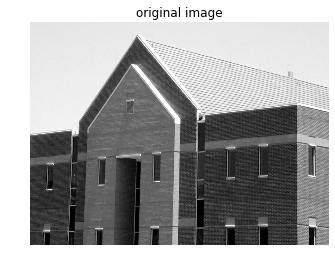

In [15]:
img_building = 'building.tif'
a = mpimg.imread(img_building)
plotGreyImage(a, "original image")

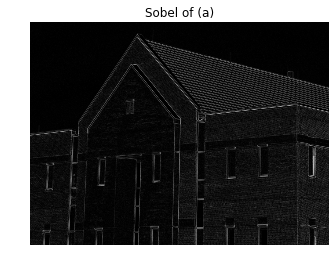

In [21]:
sobel = convolution(a, partial(sobel_3x3_filter), np.asarray([3,3]))

plotGreyImage(sobel, "Sobel of (a)")

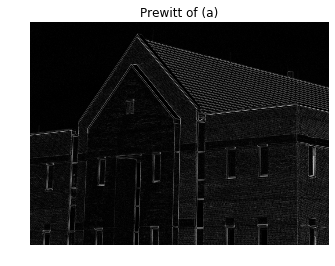

In [22]:
prewitt = convolution(a, partial(prewitt_3x3_filter), np.asarray([3,3]))

plotGreyImage(sobel, "Prewitt of (a)")

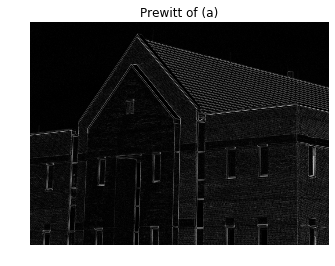

In [32]:
roberts = convolution(a, partial(roberts_2x2_filter), np.asarray([2,2]))

plotGreyImage(sobel, "Prewitt of (a)")

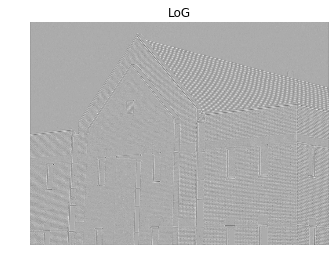

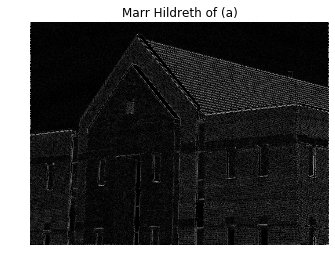

In [64]:
edges = Marr_Hildreth_edge_detector(a)
plotGreyImage(edges, "Marr Hildreth of (a)")

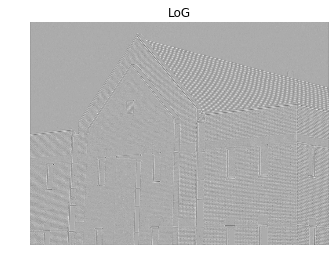

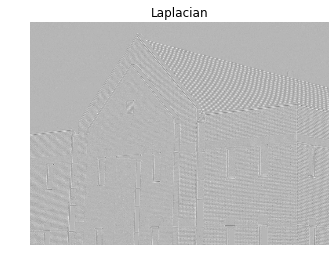

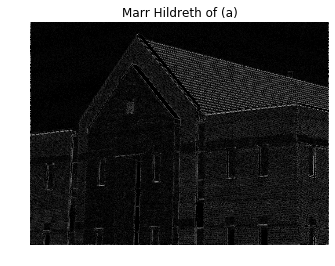

In [67]:
edges = Marr_Hildreth_edge_detector(a, threshold = 0.04 * np.max(a))
plotGreyImage(edges, "Marr Hildreth of (a)")

In [ ]:
#todo:  Canny edge detectors

### (b). Develop a program to implement the Otsu’s method of thresholding segmentation, and compare the results with the global thresholding method

In [83]:
def basic_global_thresholding(img, deltaT, v = True):
    
    T = np.average(img)
    
    i = 0
    currentDelta = deltaT + 1
    while (currentDelta > deltaT):
        m1 = np.mean(img[img > T])
        m2 = np.mean(img[img <= T])
        
        T_new = 0.5 * (m1 + m2)
        currentDelta = np.abs(T_new - T)
        
        T = T_new
        i +=1
    
    if (v): 
        print("Number of iterations: " + str(i) + "\nresulting T = " + str(T))
    
    return T

In [102]:
def apply_thresholding(img, T):
    new_img = np.copy(img)
    new_img[img > T] = 1.0
    new_img[img <= T] = 0.0
    
    return new_img    

In [86]:
def draw_histogram(greyvalues, cdf, normed = False):
    valueRange = len(greyvalues)
    
    #plot histogram        
    fig, ax1 = plt.subplots()   
    
    if (normed):
        ax1.set_title("normed histogram")
    else:
        ax1.set_title("histogram")
    
    index = np.arange(valueRange)
    
    if (normed):
        ax1.bar(index, greyvalues  / float(np.sum(greyvalues)), 0.35, alpha=0.4, color='b')
    else:
        ax1.bar(index, greyvalues, 0.35, alpha=0.4, color='b')
    ax1.set_ylabel('count', color='b')
    ax1.set_xlabel('pixel intensities')
    ax1.set_xlim((0,valueRange))    
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
        
    #plot cdf
    ax2 = ax1.twinx()    
    if (normed):
        ax2.plot(index, cdf / float(np.sum(greyvalues)), color = 'r') 
        ax2.set_ylim((0,1.1))
    else:
        ax2.plot(index, cdf, color = 'r')     
    ax2.set_ylabel('cdf', color = 'r')
    ax2.set_xlim((0,valueRange))
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()    

In [87]:
#my implementation of histogram
def histogram(image):
    values = np.asmatrix(image,dtype=int).A1
        
    valueRange = np.max(values) + 1  
    index = np.arange(valueRange)
    
    greyvalues = np.asarray([0]*valueRange, dtype = float)
    
    for i in range(len(values)):
        greyvalues[values[i]] += 1
    
    #calculate CDF
    sum = 0.0
    cdf = np.asarray([0.0] * valueRange, dtype = float)
    for i in index:
        cdf[i] = sum + greyvalues[i]
        sum += greyvalues[i]
        
    return (greyvalues, cdf)

In [90]:
def draw_hist(img):
    greyvalues,cdf = histogram(img)
    draw_histogram(greyvalues, cdf, normed = True)

In [117]:
def otsus_method(img):
    #1. Compute the normalized histogram of the input image: p
    greyvalues,cdf = histogram(img)
    p = greyvalues / float(np.sum(greyvalues))

    #2. Compute the cumulative sums: P
    P = cdf / float(np.sum(greyvalues))

    #3. Compute the cumulative means: m
    m = np.zeros(p.shape)
    for i in np.arange(1,len(P),1):
        m[i] = m[i-1] + i * p[i]

    #4. Compute the global intensity mean m_G
    m_G = m[-1]

    #5. Compute the between-class variance: var_b
    var_b = np.zeros(p.shape)
    for k in range(len(P)):
        var_b[k] = np.power((m_G * P[k] - m[k]),2) / (P[k] * (1 - P[k]))

    #6. Obtain the Otsu treshold, k*, as the value of k for which var_b is maximimum. 
    var_b[np.isnan(var_b)] = 0.0
    max_indices = np.argmax(var_b)

    #If the maximum is not unique, obtain k* by averaging the values of k corresponding to the various maxima detected
    k = np.average(max_indices)
    
    return k

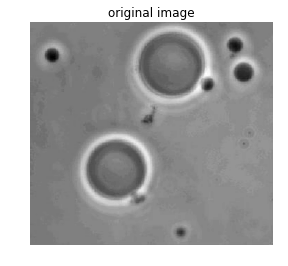

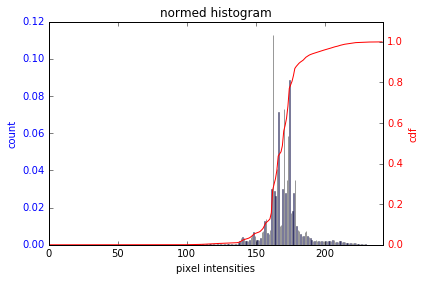

In [91]:
img_polymersomes = 'polymersomes.tif'
polymersomes = mpimg.imread(img_polymersomes)
plotGreyImage(polymersomes, "original image")
draw_hist(polymersomes)

Number of iterations: 2
resulting T = 169.394997463


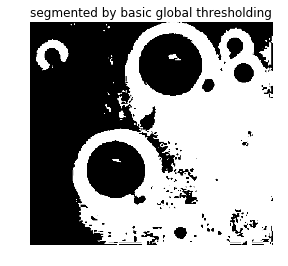

In [103]:
T = basic_global_thresholding(polymersomes, 0.0001)

segmented = apply_thresholding(polymersomes, T)
plotGreyImage(segmented, "segmented by basic global thresholding")

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars


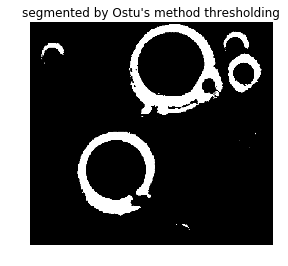

In [116]:
k = otsus_method(polymersomes)
segmented = apply_thresholding(polymersomes, k)
plotGreyImage(segmented, "segmented by Ostu's method thresholding")